# Unsupervised Learning Trading Strategy


*   Download SP500 stocks data
*   Calculate different features and indicators on each stock
*   Aggregate on monthly levels and filter top 150 most liquid stocks
*   Use Unsupervised Machine Learning to create stock cluster
*   Based on our Hypothesis, select the required cluster to consider
*   Create a weighted Portfolio using Max Sharpe Optimization
*   Update the portfolio every month
*   Visualize the Results with respect to S&P500 Buy and Hold





In [ ]:
#Import required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import datetime as dt
import yfinance as yf
!pip install pandas_ta
import pandas_ta
import sklearn
import warnings
warnings.filterwarnings('ignore')
!pip install PyPortfolioOpt



In [ ]:
#Get list of current SP500 stocks
sp500 = pd.read_html("https://en.wikipedia.org/wiki/List_of_S%26P_500_companies")[0]
sp500['Symbol'] = sp500['Symbol'].str.replace('.','-')
symbols_list = sp500['Symbol'].unique().tolist()
#There is a survivorship bias involved as only current companies in S&P index are used
end_date = "2024-01-09"
start_date = pd.to_datetime(end_date) - pd.DateOffset(365*8)

df = yf.download(tickers = symbols_list,
                 start= start_date,
                 end = end_date).stack()


[*********************100%%**********************]  503 of 503 completed


In [ ]:
df.index.names = ['date','ticker']
df.columns = df.columns.str.lower()
df

adj close       close        high         low        open  \
date       ticker                                                               
2016-01-11 A        35.557152   37.939999   38.900002   37.410000   38.709999   
           AAL      39.257912   41.080002   41.200001   39.900002   40.560001   
           AAPL     22.425255   24.632500   24.764999   24.334999   24.742500   
           ABBV     38.137867   53.880001   55.980000   52.830002   55.860001   
           ABT      35.062435   40.730000   40.900002   40.099998   40.770000   
...                       ...         ...         ...         ...         ...   
2024-01-08 YUM     128.639999  128.639999  128.779999  127.180000  128.210007   
           ZBH     121.970001  121.970001  122.779999  120.519997  120.629997   
           ZBRA    261.089996  261.089996  262.279999  251.360001  252.110001   
           ZION     44.540001   44.540001   44.590000   43.400002   43.779999   
           ZTS     196.149994  196.149994  196.279999  192.669998  194.529999   

                        volume  
date       ticker               
2016-01-11 A         2818400.0  
           AAL      15877500.0  
           AAPL    198957600.0  
           ABBV     10483300.0  
           ABT       7839700.0  
...                        ...  
2024-01-08 YUM       1204100.0  
           ZBH       1427600.0  
           ZBRA       399500.0  
           ZION      1805000.0  
           ZTS       1610600.0  

[994608 rows x 6 columns]

#Calculate Technical Indicators and Features

Garman-Klass Volatility
RSI
Bollinger Band

In [ ]:
df['garman_klass_vol'] = ((np.log(df['high']) - np.log(df['low']))**2)/2 - (2*np.log(2)-1)*((np.log(df['adj close'])- np.log(df['open']))**2)
df['rsi'] = df.groupby(level =1)['adj close'].transform(lambda x:pandas_ta.rsi(close=x,length =20))
df['bb_low'] = df.groupby(level =1)['adj close'].transform(lambda x: pandas_ta.bbands(close =np.log1p(x),length=20).iloc[:,0])
df['bb_mid'] = df.groupby(level =1)['adj close'].transform(lambda x: pandas_ta.bbands(close =np.log1p(x),length=20).iloc[:,1])
df['bb_high'] = df.groupby(level =1)['adj close'].transform(lambda x: pandas_ta.bbands(close =np.log1p(x),length=20).iloc[:,2])

In [ ]:
#Compute ATR
def compute_atr(stock_data):
  atr = pandas_ta.atr(high = stock_data['high'],
                      low = stock_data['low'],
                      close = stock_data['close'],
                      length = 14)
  return atr.sub(atr.mean()).div(atr.std())

df['atr'] = df.groupby(level =1 , group_keys = False).apply(compute_atr)
df

adj close       close        high         low        open  \
date       ticker                                                               
2016-01-11 A        35.557152   37.939999   38.900002   37.410000   38.709999   
           AAL      39.257912   41.080002   41.200001   39.900002   40.560001   
           AAPL     22.425255   24.632500   24.764999   24.334999   24.742500   
           ABBV     38.137867   53.880001   55.980000   52.830002   55.860001   
           ABT      35.062435   40.730000   40.900002   40.099998   40.770000   
...                       ...         ...         ...         ...         ...   
2024-01-08 YUM     128.639999  128.639999  128.779999  127.180000  128.210007   
           ZBH     121.970001  121.970001  122.779999  120.519997  120.629997   
           ZBRA    261.089996  261.089996  262.279999  251.360001  252.110001   
           ZION     44.540001   44.540001   44.590000   43.400002   43.779999   
           ZTS     196.149994  196.149994  196.279999  192.669998  194.529999   

                        volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                       
2016-01-11 A         2818400.0         -0.002025        NaN       NaN   
           AAL      15877500.0          0.000103        NaN       NaN   
           AAPL    198957600.0         -0.003582        NaN       NaN   
           ABBV     10483300.0         -0.054587        NaN       NaN   
           ABT       7839700.0         -0.008591        NaN       NaN   
...                        ...               ...        ...       ...   
2024-01-08 YUM       1204100.0          0.000074  52.860944  4.844758   
           ZBH       1427600.0          0.000125  66.171947  4.767563   
           ZBRA       399500.0          0.000431  57.299208  5.468280   
           ZION      1805000.0          0.000251  61.937395  3.684914   
           ZTS       1610600.0          0.000146  62.497298  5.243583   

                     bb_mid   bb_high       atr  
date       ticker                                
2016-01-11 A            NaN       NaN       NaN  
           AAL          NaN       NaN       NaN  
           AAPL         NaN       NaN       NaN  
           ABBV         NaN       NaN       NaN  
           ABT          NaN       NaN       NaN  
...                     ...       ...       ...  
2024-01-08 YUM     4.869583  4.894407 -0.083234  
           ZBH     4.793275  4.818987 -0.984562  
           ZBRA    5.567432  5.666583 -0.008954  
           ZION    3.782390  3.879866  0.325139  
           ZTS     5.277933  5.312282  0.394179  

[994608 rows x 12 columns]

In [ ]:
def compute_macd(close):
  macd = pandas_ta.macd(close = close, length =20).iloc[:,0]
  return macd.sub(macd.mean()).div(macd.std())

df['macd'] = df.groupby(level =1 , group_keys = False)['adj close'].apply(compute_macd)
df

adj close       close        high         low        open  \
date       ticker                                                               
2016-01-11 A        35.557152   37.939999   38.900002   37.410000   38.709999   
           AAL      39.257912   41.080002   41.200001   39.900002   40.560001   
           AAPL     22.425255   24.632500   24.764999   24.334999   24.742500   
           ABBV     38.137867   53.880001   55.980000   52.830002   55.860001   
           ABT      35.062435   40.730000   40.900002   40.099998   40.770000   
...                       ...         ...         ...         ...         ...   
2024-01-08 YUM     128.639999  128.639999  128.779999  127.180000  128.210007   
           ZBH     121.970001  121.970001  122.779999  120.519997  120.629997   
           ZBRA    261.089996  261.089996  262.279999  251.360001  252.110001   
           ZION     44.540001   44.540001   44.590000   43.400002   43.779999   
           ZTS     196.149994  196.149994  196.279999  192.669998  194.529999   

                        volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                       
2016-01-11 A         2818400.0         -0.002025        NaN       NaN   
           AAL      15877500.0          0.000103        NaN       NaN   
           AAPL    198957600.0         -0.003582        NaN       NaN   
           ABBV     10483300.0         -0.054587        NaN       NaN   
           ABT       7839700.0         -0.008591        NaN       NaN   
...                        ...               ...        ...       ...   
2024-01-08 YUM       1204100.0          0.000074  52.860944  4.844758   
           ZBH       1427600.0          0.000125  66.171947  4.767563   
           ZBRA       399500.0          0.000431  57.299208  5.468280   
           ZION      1805000.0          0.000251  61.937395  3.684914   
           ZTS       1610600.0          0.000146  62.497298  5.243583   

                     bb_mid   bb_high       atr      macd  
date       ticker                                          
2016-01-11 A            NaN       NaN       NaN       NaN  
           AAL          NaN       NaN       NaN       NaN  
           AAPL         NaN       NaN       NaN       NaN  
           ABBV         NaN       NaN       NaN       NaN  
           ABT          NaN       NaN       NaN       NaN  
...                     ...       ...       ...       ...  
2024-01-08 YUM     4.869583  4.894407 -0.083234  0.277219  
           ZBH     4.793275  4.818987 -0.984562  0.748902  
           ZBRA    5.567432  5.666583 -0.008954  0.749927  
           ZION    3.782390  3.879866  0.325139  1.514686  
           ZTS     5.277933  5.312282  0.394179  1.429557  

[994608 rows x 13 columns]

In [ ]:
df['dollar_volume'] = (df['adj close']*df['volume'])/1e6


In [ ]:
df

adj close       close        high         low        open  \
date       ticker                                                               
2016-01-11 A        35.557152   37.939999   38.900002   37.410000   38.709999   
           AAL      39.257912   41.080002   41.200001   39.900002   40.560001   
           AAPL     22.425255   24.632500   24.764999   24.334999   24.742500   
           ABBV     38.137867   53.880001   55.980000   52.830002   55.860001   
           ABT      35.062435   40.730000   40.900002   40.099998   40.770000   
...                       ...         ...         ...         ...         ...   
2024-01-08 YUM     128.639999  128.639999  128.779999  127.180000  128.210007   
           ZBH     121.970001  121.970001  122.779999  120.519997  120.629997   
           ZBRA    261.089996  261.089996  262.279999  251.360001  252.110001   
           ZION     44.540001   44.540001   44.590000   43.400002   43.779999   
           ZTS     196.149994  196.149994  196.279999  192.669998  194.529999   

                        volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                       
2016-01-11 A         2818400.0         -0.002025        NaN       NaN   
           AAL      15877500.0          0.000103        NaN       NaN   
           AAPL    198957600.0         -0.003582        NaN       NaN   
           ABBV     10483300.0         -0.054587        NaN       NaN   
           ABT       7839700.0         -0.008591        NaN       NaN   
...                        ...               ...        ...       ...   
2024-01-08 YUM       1204100.0          0.000074  52.860944  4.844758   
           ZBH       1427600.0          0.000125  66.171947  4.767563   
           ZBRA       399500.0          0.000431  57.299208  5.468280   
           ZION      1805000.0          0.000251  61.937395  3.684914   
           ZTS       1610600.0          0.000146  62.497298  5.243583   

                     bb_mid   bb_high       atr      macd  dollar_volume  
date       ticker                                                         
2016-01-11 A            NaN       NaN       NaN       NaN     100.214277  
           AAL          NaN       NaN       NaN       NaN     623.317493  
           AAPL         NaN       NaN       NaN       NaN    4461.674879  
           ABBV         NaN       NaN       NaN       NaN     399.810701  
           ABT          NaN       NaN       NaN       NaN     274.878973  
...                     ...       ...       ...       ...            ...  
2024-01-08 YUM     4.869583  4.894407 -0.083234  0.277219     154.895423  
           ZBH     4.793275  4.818987 -0.984562  0.748902     174.124374  
           ZBRA    5.567432  5.666583 -0.008954  0.749927     104.305454  
           ZION    3.782390  3.879866  0.325139  1.514686      80.394702  
           ZTS     5.277933  5.312282  0.394179  1.429557     315.919180  

[994608 rows x 14 columns]

Aggregate to monthly level and filter top 150 stocks liquid stocks

In [ ]:
last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume','volume','open','close','high','low']]
last_cols


['adj close',
 'garman_klass_vol',
 'rsi',
 'bb_low',
 'bb_mid',
 'bb_high',
 'atr',
 'macd']

In [ ]:

data = (pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'),
df.unstack()[last_cols].resample('M').last().stack('ticker')],axis =1)).dropna()
data

dollar_volume   adj close       atr   bb_high    bb_low  \
date       ticker                                                            
2016-02-29 A           91.918053   35.004200 -0.942287  3.620122  3.522493   
           AAL        338.977803   39.288376  0.978892  3.729458  3.547833   
           AAPL      3548.073804   22.125887 -1.024714  3.155194  3.106253   
           ABBV       357.006448   39.060577 -0.484052  3.734669  3.638599   
           ABT        245.865722   33.559807 -0.796842  3.570935  3.483742   
...                          ...         ...       ...       ...       ...   
2024-01-31 YUM        221.479391  128.639999 -0.083234  4.894407  4.844758   
           ZBH        201.103381  121.970001 -0.984562  4.818987  4.767563   
           ZBRA        98.529354  261.089996 -0.008954  5.666583  5.468280   
           ZION       100.724757   44.540001  0.325139  3.879866  3.684914   
           ZTS        299.633804  196.149994  0.394179  5.312282  5.243583   

                     bb_mid  garman_klass_vol      macd        rsi  
date       ticker                                                   
2016-02-29 A       3.571307         -0.001914 -0.161368  50.730030  
           AAL     3.638645         -0.000319  0.621438  56.744017  
           AAPL    3.130723         -0.003013 -0.309435  50.633129  
           ABBV    3.686634         -0.049102 -0.336689  49.898516  
           ABT     3.527338         -0.009363 -0.346401  48.856146  
...                     ...               ...       ...        ...  
2024-01-31 YUM     4.869583          0.000074  0.277219  52.860944  
           ZBH     4.793275          0.000125  0.748902  66.171947  
           ZBRA    5.567432          0.000431  0.749927  57.299208  
           ZION    3.782390          0.000251  1.514686  61.937395  
           ZTS     5.277933          0.000146  1.429557  62.497298  

[47456 rows x 9 columns]

In [ ]:
data['dollar_volume'] = data.loc[:,'dollar_volume'].unstack('ticker').rolling(5*12, min_periods =12).mean().stack()
data['dollar_vol_rank'] = data.groupby('date')['dollar_volume'].rank(ascending= False)


In [ ]:
data = data[data['dollar_vol_rank']<150].drop(['dollar_volume','dollar_vol_rank'],axis =1 )

In [ ]:
data

adj close       atr   bb_high    bb_low    bb_mid  \
date       ticker                                                       
2017-01-31 AAL      42.760246  1.307111  3.891346  3.789144  3.840245   
           AAPL     28.233547 -1.195413  3.389455  3.332440  3.360948   
           ABBV     45.380966 -1.207250  3.877335  3.814875  3.846105   
           ABT      37.100903 -1.169352  3.643741  3.577130  3.610435   
           ACN     102.222733 -1.025139  4.667883  4.637933  4.652908   
...                       ...       ...       ...       ...       ...   
2024-01-31 VRTX    419.119995  0.896759  6.096495  5.890271  5.993383   
           VZ       39.434998 -0.715602  3.695393  3.600114  3.647754   
           WFC      49.919998 -0.584578  3.964528  3.858160  3.911344   
           WMT     158.250000  0.001459  5.086623  5.018497  5.052560   
           XOM     100.919998  0.411267  4.653438  4.599845  4.626642   

                   garman_klass_vol      macd        rsi  
date       ticker                                         
2017-01-31 AAL            -0.000522 -0.169936  42.277602  
           AAPL           -0.001885 -0.108113  67.547636  
           ABBV           -0.029823 -0.327047  49.245574  
           ABT            -0.002947  0.197853  66.810925  
           ACN            -0.004494 -0.452610  41.080214  
...                             ...       ...        ...  
2024-01-31 VRTX            0.000099  3.180246  70.436989  
           VZ              0.000067  1.415686  70.651153  
           WFC             0.000098  1.489961  67.657136  
           WMT             0.000015  0.102704  52.882907  
           XOM             0.000228 -0.311459  45.747642  

[12665 rows x 8 columns]

#Calculate Monthly Returns for different time horizon as features


In [ ]:
def calculate_returns(df):

    outlier_cutoff = 0.005

    lags = [1, 2, 3, 6, 9, 12]

    for lag in lags:

        df[f'return_{lag}m'] = (df['adj close']
                              .pct_change(lag)
                              .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                     upper=x.quantile(1-outlier_cutoff)))
                              .add(1)
                              .pow(1/lag)
                              .sub(1))
    return df


data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()

data

adj close       atr   bb_high    bb_low    bb_mid  \
date       ticker                                                       
2018-01-31 AAL      52.943859  1.287350  4.089372  3.908840  3.999106   
           AAPL     39.581043 -0.964250  3.781592  3.700759  3.741176   
           ABBV     86.127289  1.477448  4.536019  4.272025  4.404022   
           ABT      56.398468 -0.697169  4.073903  3.956251  4.015077   
           ACN     147.171097 -0.987859  5.015497  4.968583  4.992040   
...                       ...       ...       ...       ...       ...   
2024-01-31 VRTX    419.119995  0.896759  6.096495  5.890271  5.993383   
           VZ       39.434998 -0.715602  3.695393  3.600114  3.647754   
           WFC      49.919998 -0.584578  3.964528  3.858160  3.911344   
           WMT     158.250000  0.001459  5.086623  5.018497  5.052560   
           XOM     100.919998  0.411267  4.653438  4.599845  4.626642   

                   garman_klass_vol      macd        rsi  return_1m  \
date       ticker                                                     
2018-01-31 AAL             0.000502  0.612707  53.332139   0.044013   
           AAPL           -0.001000 -0.414605  40.100720  -0.010636   
           ABBV           -0.033621  2.074100  62.305750   0.168700   
           ABT            -0.004175  0.966303  69.274849   0.094397   
           ACN            -0.002706  0.290279  63.135353   0.049710   
...                             ...       ...        ...        ...   
2024-01-31 VRTX            0.000099  3.180246  70.436989   0.030057   
           VZ              0.000067  1.415686  70.651153   0.063660   
           WFC             0.000098  1.489961  67.657136   0.014222   
           WMT             0.000015  0.102704  52.882907   0.003806   
           XOM             0.000228 -0.311459  45.747642   0.009402   

                   return_2m  return_3m  return_6m  return_9m  return_12m  
date       ticker                                                          
2018-01-31 AAL      0.037235   0.051541   0.013139   0.028045    0.017961  
           AAPL    -0.012944  -0.001992   0.021212   0.018481    0.028553  
           ABBV     0.079893   0.077893   0.081654   0.063580    0.054846  
           ABT      0.052610   0.048209   0.041483   0.041085    0.035516  
           ACN      0.041987   0.041220   0.039209   0.032852    0.030836  
...                      ...        ...        ...        ...         ...  
2024-01-31 VRTX     0.086854   0.049944   0.029349   0.023274    0.021920  
           VZ       0.022828   0.045094   0.031105   0.007925    0.001608  
           WFC      0.058080   0.081910   0.015955   0.028427    0.007852  
           WMT      0.010058  -0.009415  -0.000478   0.006481    0.009243  
           XOM     -0.008897  -0.012782  -0.007220  -0.014705   -0.008776  

[10489 rows x 14 columns]

#Download Fama-French Factors and calculate rolling factor betas

In [ ]:
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
                               'famafrench',
                               start='2010')[0].drop('RF', axis=1)

factor_data.index = factor_data.index.to_timestamp()

factor_data = factor_data.resample('M').last().div(100)

factor_data.index.name = 'date'

factor_data = factor_data.join(data['return_1m']).sort_index()

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2018-01-31 AAL     0.0557 -0.0318 -0.0129 -0.0076 -0.0096   0.044013
           AAPL    0.0557 -0.0318 -0.0129 -0.0076 -0.0096  -0.010636
           ABBV    0.0557 -0.0318 -0.0129 -0.0076 -0.0096   0.168700
           ABT     0.0557 -0.0318 -0.0129 -0.0076 -0.0096   0.094397
           ACN     0.0557 -0.0318 -0.0129 -0.0076 -0.0096   0.049710
...                   ...     ...     ...     ...     ...        ...
2023-11-30 VRTX    0.0884 -0.0010  0.0165 -0.0389 -0.0099  -0.020160
           VZ      0.0884 -0.0010  0.0165 -0.0389 -0.0099   0.091090
           WFC     0.0884 -0.0010  0.0165 -0.0389 -0.0099   0.131192
           WMT     0.0884 -0.0010  0.0165 -0.0389 -0.0099  -0.047243
           XOM     0.0884 -0.0010  0.0165 -0.0389 -0.0099  -0.020506

[10197 rows x 6 columns]

In [ ]:
#filter out stocks with 10 months of data ( using long-term indicators)
observations = factor_data.groupby(level=1).size()

valid_stocks = observations[observations >= 10]

factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2018-01-31 AAL     0.0557 -0.0318 -0.0129 -0.0076 -0.0096   0.044013
           AAPL    0.0557 -0.0318 -0.0129 -0.0076 -0.0096  -0.010636
           ABBV    0.0557 -0.0318 -0.0129 -0.0076 -0.0096   0.168700
           ABT     0.0557 -0.0318 -0.0129 -0.0076 -0.0096   0.094397
           ACN     0.0557 -0.0318 -0.0129 -0.0076 -0.0096   0.049710
...                   ...     ...     ...     ...     ...        ...
2023-11-30 VRTX    0.0884 -0.0010  0.0165 -0.0389 -0.0099  -0.020160
           VZ      0.0884 -0.0010  0.0165 -0.0389 -0.0099   0.091090
           WFC     0.0884 -0.0010  0.0165 -0.0389 -0.0099   0.131192
           WMT     0.0884 -0.0010  0.0165 -0.0389 -0.0099  -0.047243
           XOM     0.0884 -0.0010  0.0165 -0.0389 -0.0099  -0.020506

[10146 rows x 6 columns]

In [ ]:
# #Calculate rolling Factor Betas
# (factor_data.groupby(level=1,
#                      group_keys = False)
# .apply(lambda x: RollingOLS(endog = x['return_1m'],
#                              exog= sm.add_constant(x.drop('return_1m',axis =1)),
#                              window = min(24,x.shape[0]),
#                              min_nobs =len(x.columns)+1)
# .fit(params_only= True)
# .params
# .drop('const',axis=1)))
betas = (factor_data.groupby(level=1,
                            group_keys=False)
         .apply(lambda x: RollingOLS(endog=x['return_1m'],
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(24, x.shape[0]),
                                     min_nobs=len(x.columns)+1)
         .fit(params_only=True)
         .params
         .drop('const', axis=1)))

betas

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2018-01-31 AAL          NaN       NaN       NaN       NaN       NaN
           AAPL         NaN       NaN       NaN       NaN       NaN
           ABBV         NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN
           ACN          NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2023-11-30 VRTX    0.376235 -0.326701 -0.444955  0.318725  0.869058
           VZ      0.444391 -0.662954  0.517142  0.210200 -0.205916
           WFC     1.037897  0.401001  2.011854 -0.363960 -1.477539
           WMT     0.497264  0.081986 -0.730994  0.577487  0.752982
           XOM     0.722439 -0.211054  1.202662  0.229125  0.171952

[10146 rows x 5 columns]

In [ ]:
data = data.join(betas.groupby('ticker').shift())

factors = ['Mkt-RF','SMB','HML','RMW','CMA']
data.loc[:,factors] = data.groupby('ticker',group_keys = False)[factors].apply(lambda x:x.fillna(x.mean()))
data = data.dropna()

data = data.drop('adj close', axis =1)

data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10283 entries, (Timestamp('2018-01-31 00:00:00', freq='M'), 'AAL') to (Timestamp('2024-01-31 00:00:00', freq='M'), 'XOM')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   atr               10283 non-null  float64
 1   bb_high           10283 non-null  float64
 2   bb_low            10283 non-null  float64
 3   bb_mid            10283 non-null  float64
 4   garman_klass_vol  10283 non-null  float64
 5   macd              10283 non-null  float64
 6   rsi               10283 non-null  float64
 7   return_1m         10283 non-null  float64
 8   return_2m         10283 non-null  float64
 9   return_3m         10283 non-null  float64
 10  return_6m         10283 non-null  float64
 11  return_9m         10283 non-null  float64
 12  return_12m        10283 non-null  float64
 13  Mkt-RF            10283 non-null  float64
 14  SMB               10283 non-null  floa

In [ ]:
#Machine learning for which course to have in portfolio






#Machine learning to maintain and update our stock market portfolio

#Machine learning for which course to have in Stock Market Portfolio

In [ ]:
from sklearn.cluster import KMeans

target_rsi_values = [30,45,55,70]
initial_centroids = np.zeros((len(target_rsi_values),18))
initial_centroids[:,6] =target_rsi_values

def get_clusters(df):
  df['cluster'] = KMeans(n_clusters=  4,
                         random_state = 0,
                         init = initial_centroids).fit(df).labels_

  return df

data = data.dropna().groupby('date',group_keys = False).apply(get_clusters)

data

atr   bb_high    bb_low    bb_mid  garman_klass_vol  \
date       ticker                                                             
2018-01-31 AAL     1.287350  4.089372  3.908840  3.999106          0.000502   
           AAPL   -0.964250  3.781592  3.700759  3.741176         -0.001000   
           ABBV    1.477448  4.536019  4.272025  4.404022         -0.033621   
           ABT    -0.697169  4.073903  3.956251  4.015077         -0.004175   
           ACN    -0.987859  5.015497  4.968583  4.992040         -0.002706   
...                     ...       ...       ...       ...               ...   
2024-01-31 VRTX    0.896759  6.096495  5.890271  5.993383          0.000099   
           VZ     -0.715602  3.695393  3.600114  3.647754          0.000067   
           WFC    -0.584578  3.964528  3.858160  3.911344          0.000098   
           WMT     0.001459  5.086623  5.018497  5.052560          0.000015   
           XOM     0.411267  4.653438  4.599845  4.626642          0.000228   

                       macd        rsi  return_1m  return_2m  return_3m  \
date       ticker                                                         
2018-01-31 AAL     0.612707  53.332139   0.044013   0.037235   0.051541   
           AAPL   -0.414605  40.100720  -0.010636  -0.012944  -0.001992   
           ABBV    2.074100  62.305750   0.168700   0.079893   0.077893   
           ABT     0.966303  69.274849   0.094397   0.052610   0.048209   
           ACN     0.290279  63.135353   0.049710   0.041987   0.041220   
...                     ...        ...        ...        ...        ...   
2024-01-31 VRTX    3.180246  70.436989   0.030057   0.086854   0.049944   
           VZ      1.415686  70.651153   0.063660   0.022828   0.045094   
           WFC     1.489961  67.657136   0.014222   0.058080   0.081910   
           WMT     0.102704  52.882907   0.003806   0.010058  -0.009415   
           XOM    -0.311459  45.747642   0.009402  -0.008897  -0.012782   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2018-01-31 AAL      0.013139   0.028045    0.017961  1.249736  1.364595   
           AAPL     0.021212   0.018481    0.028553  1.309701 -0.322261   
           ABBV     0.081654   0.063580    0.054846  0.471506  0.471105   
           ABT      0.041483   0.041085    0.035516  0.816740 -0.161601   
           ACN      0.039209   0.032852    0.030836  1.214364 -0.164227   
...                      ...        ...         ...       ...       ...   
2024-01-31 VRTX     0.029349   0.023274    0.021920  0.524475  0.002246   
           VZ       0.031105   0.007925    0.001608  0.488873 -0.360813   
           WFC      0.015955   0.028427    0.007852  1.075629 -0.094369   
           WMT     -0.000478   0.006481    0.009243  0.610658 -0.446031   
           XOM     -0.007220  -0.014705   -0.008776  1.138574  0.273421   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2018-01-31 AAL     0.549848  0.308941  0.675168        1  
           AAPL   -0.616120  0.569085  0.568931        0  
           ABBV   -0.092783  0.370379  0.262610        2  
           ABT    -0.518419  0.287254  0.988156        3  
           ACN    -0.309528  0.294602  0.177387        2  
...                     ...       ...       ...      ...  
2024-01-31 VRTX   -0.905770  0.132113  0.859881        3  
           VZ      0.085450  0.292010  0.474454        3  
           WFC     1.437467 -0.731780 -0.615394        3  
           WMT    -0.313552  0.315891  0.700380        2  
           XOM     0.674839 -0.489298  0.648740        1  

[10283 rows x 19 columns]

In [ ]:
def plot_clusters(data):

    cluster_0 = data[data['cluster']==0]
    cluster_1 = data[data['cluster']==1]
    cluster_2 = data[data['cluster']==2]
    cluster_3 = data[data['cluster']==3]

    plt.scatter(cluster_0.iloc[:,0] , cluster_0.iloc[:,6] , color = 'red', label='cluster 0')
    plt.scatter(cluster_1.iloc[:,0] , cluster_1.iloc[:,6] , color = 'green', label='cluster 1')
    plt.scatter(cluster_2.iloc[:,0] , cluster_2.iloc[:,6] , color = 'blue', label='cluster 2')
    plt.scatter(cluster_3.iloc[:,0] , cluster_3.iloc[:,6] , color = 'black', label='cluster 3')

    plt.legend()
    plt.show()
    return

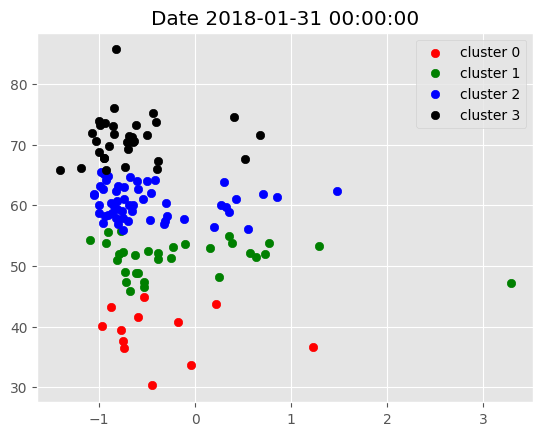

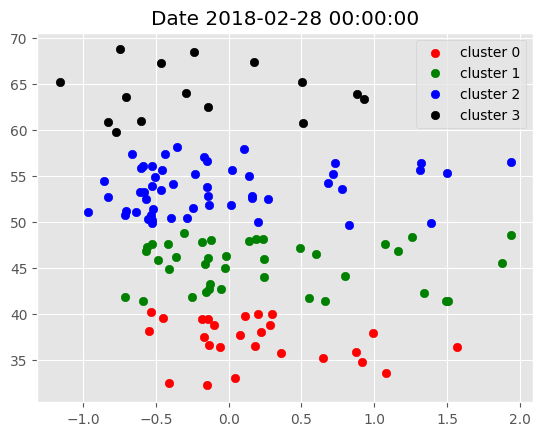

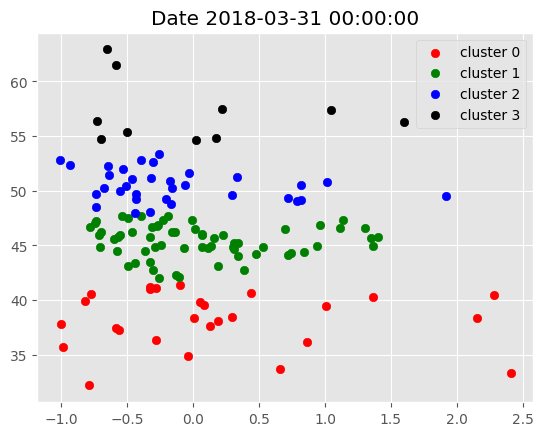

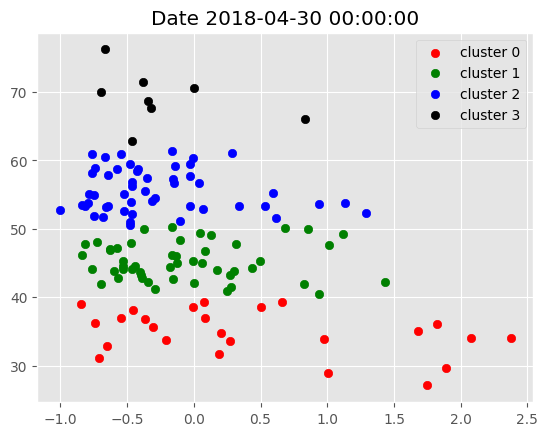

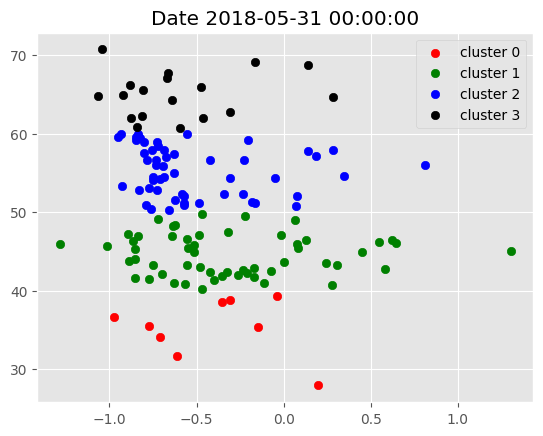

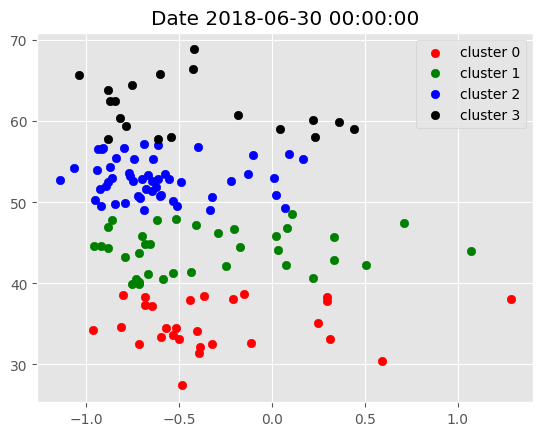

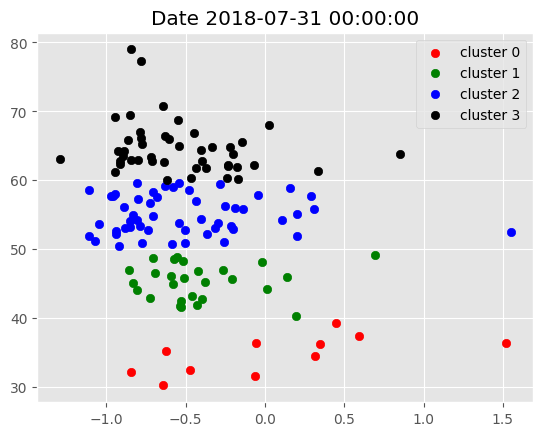

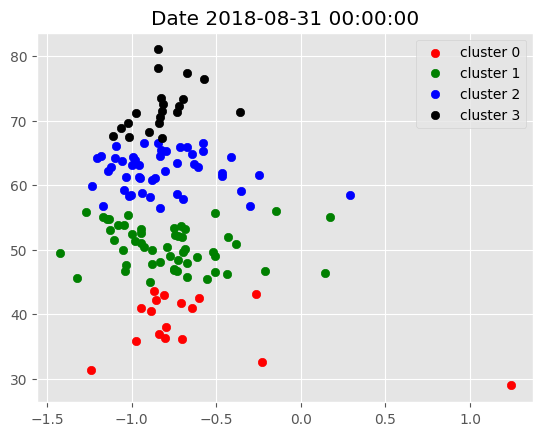

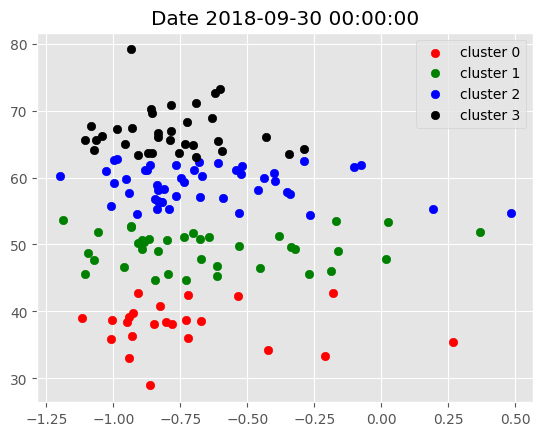

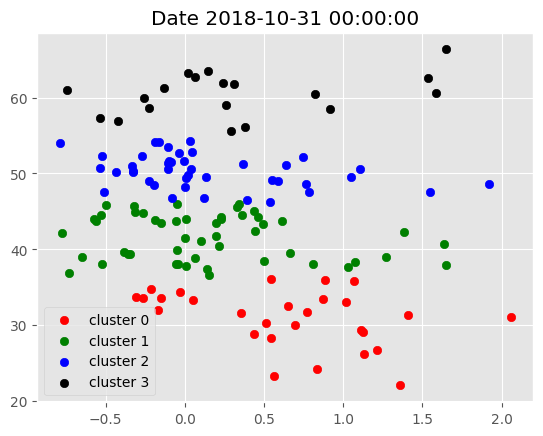

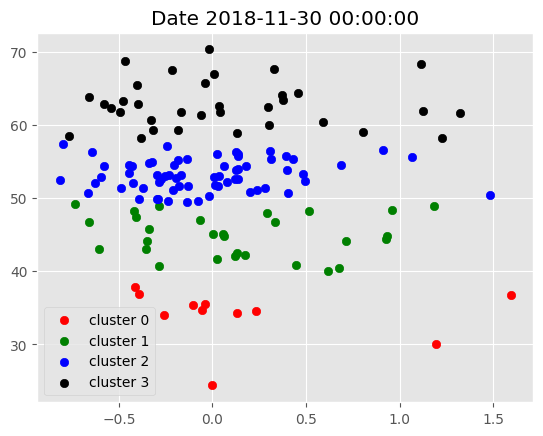

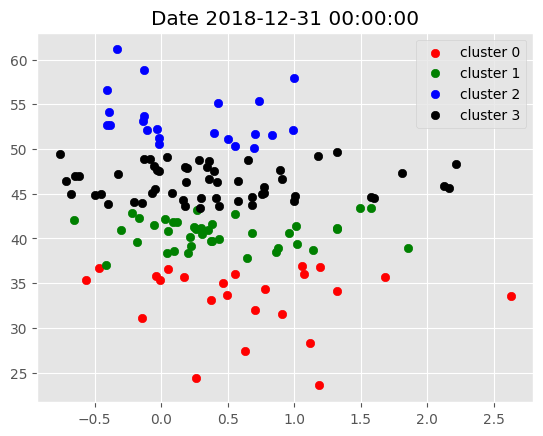

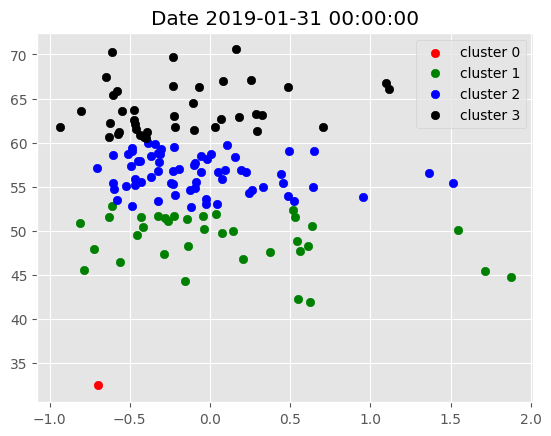

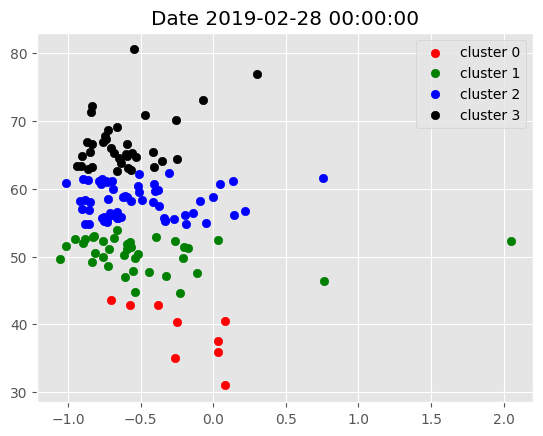

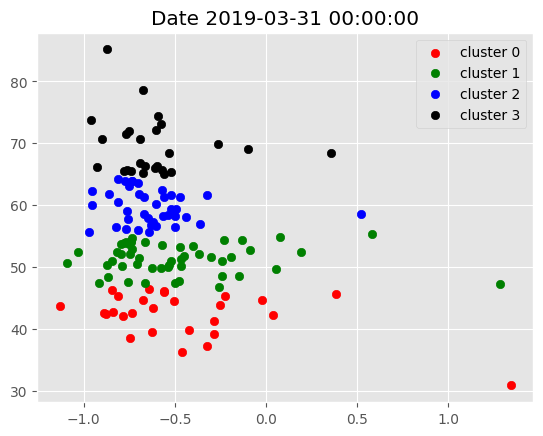

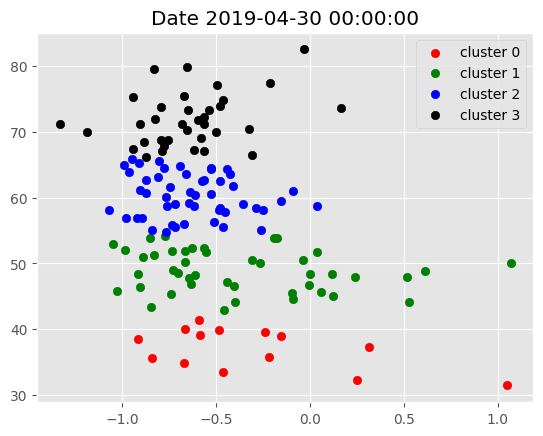

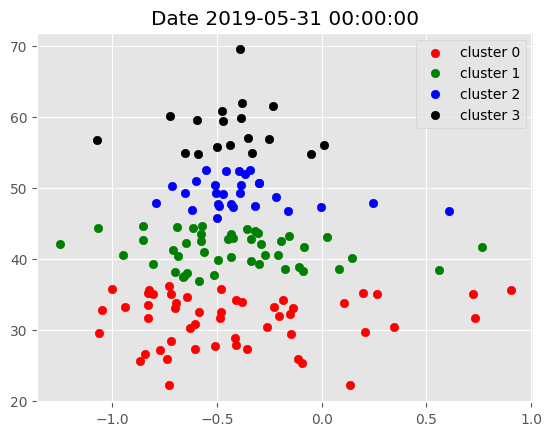

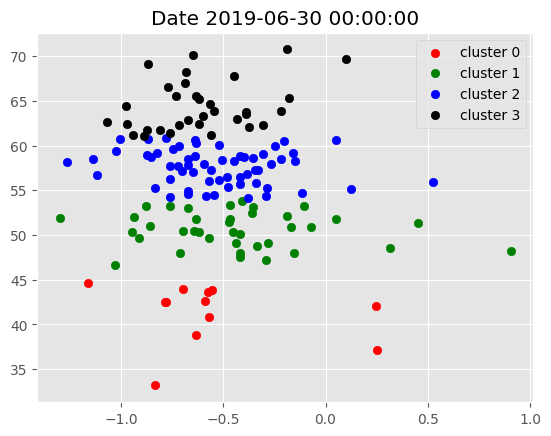

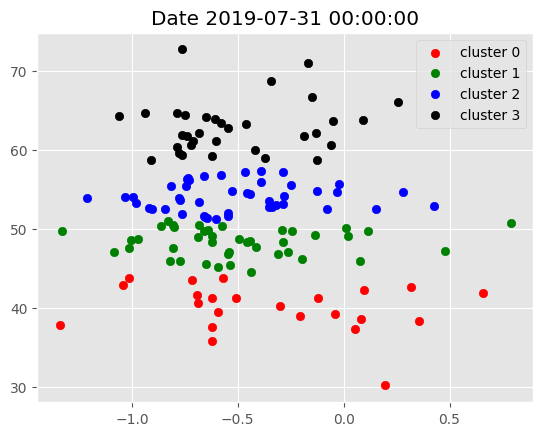

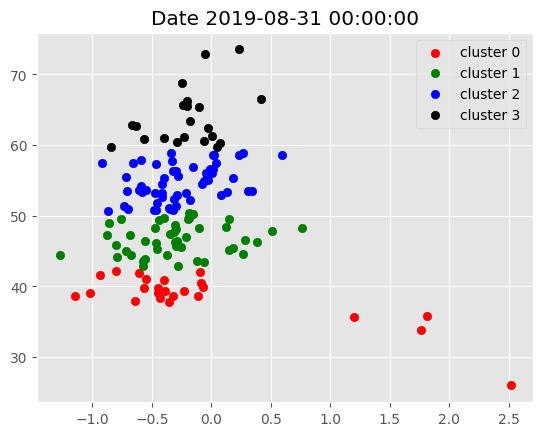

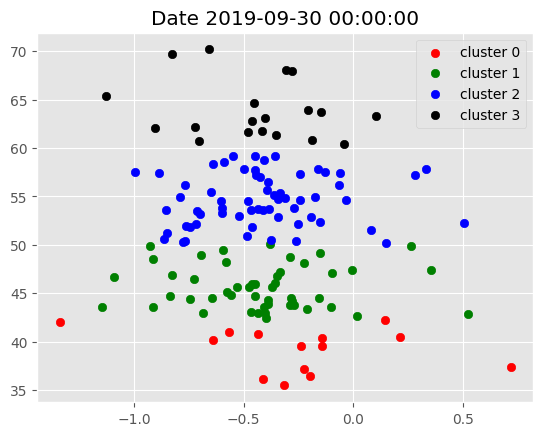

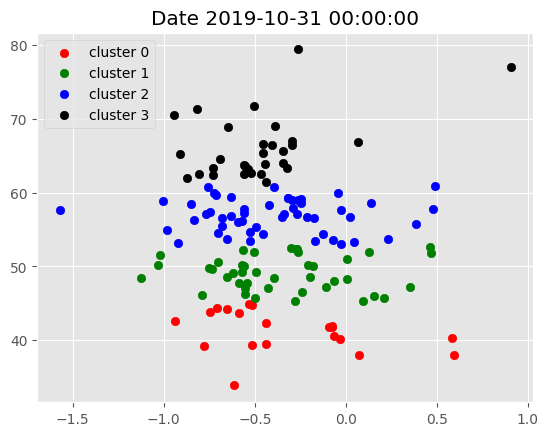

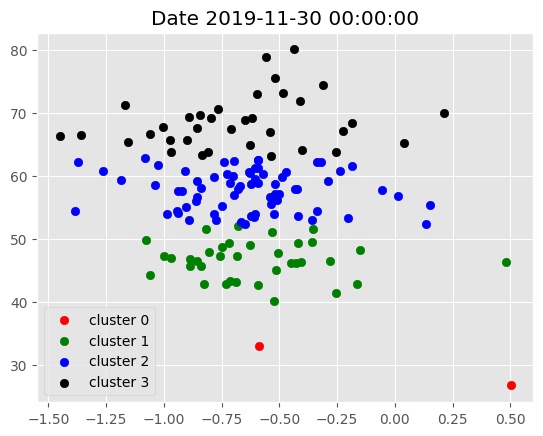

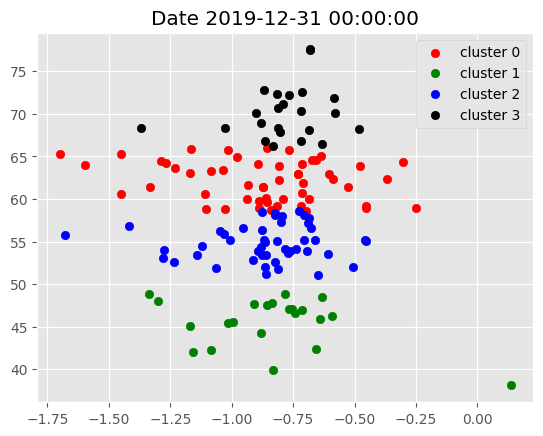

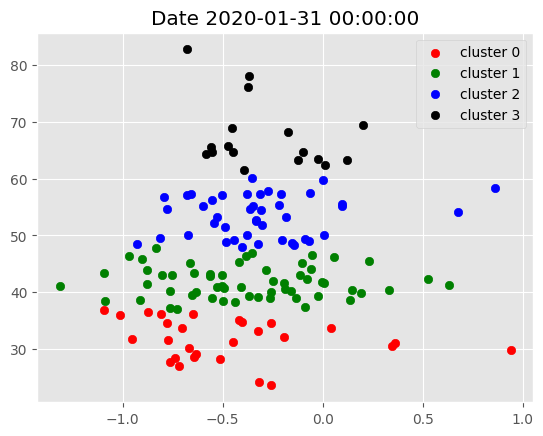

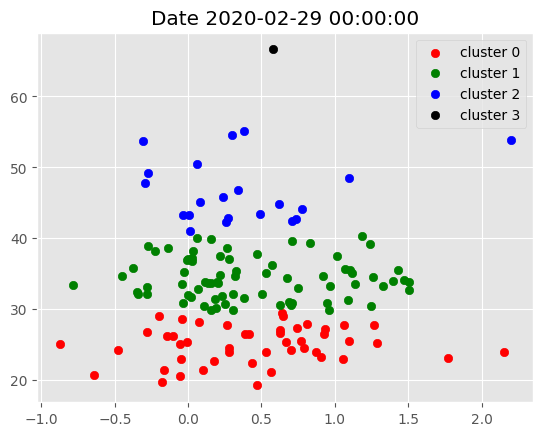

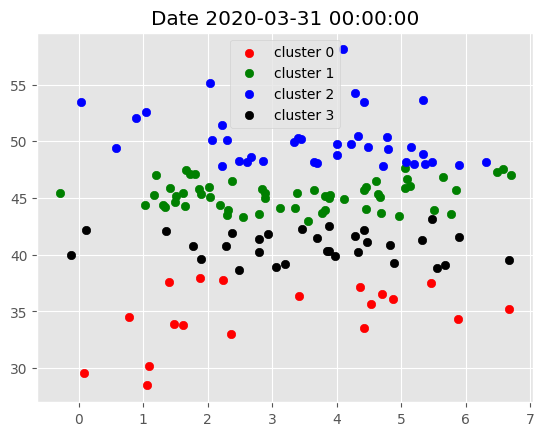

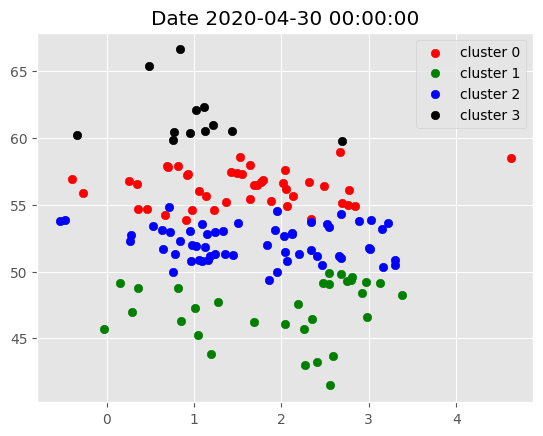

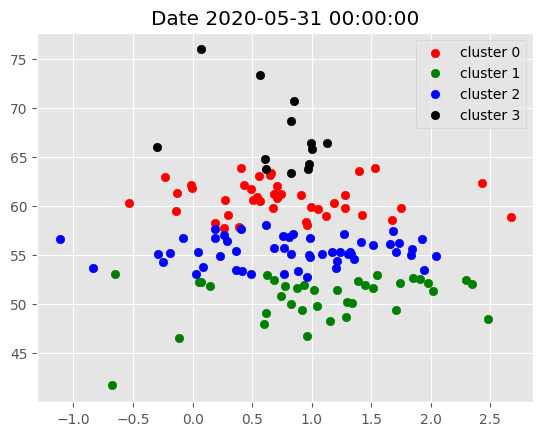

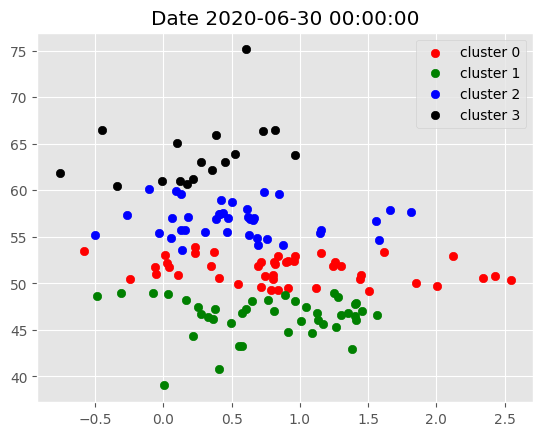

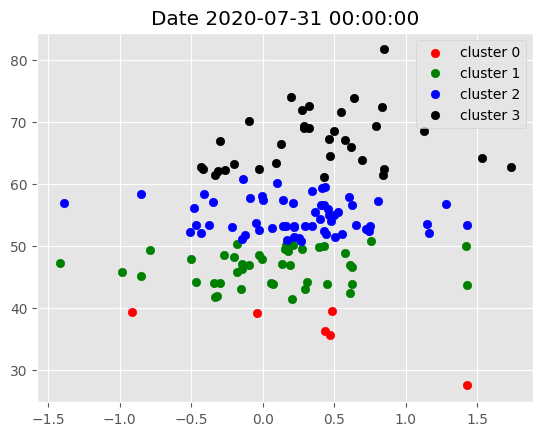

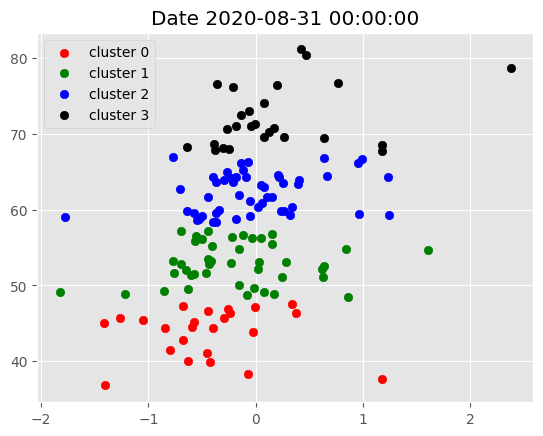

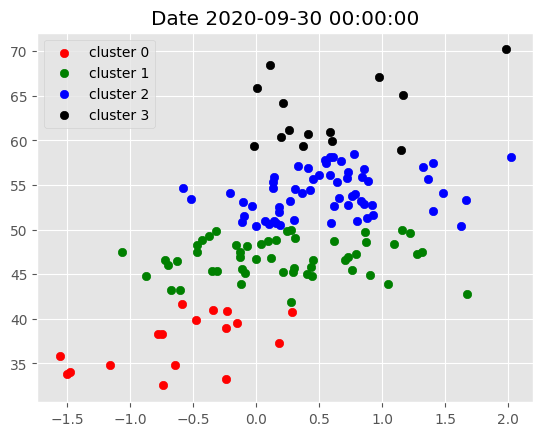

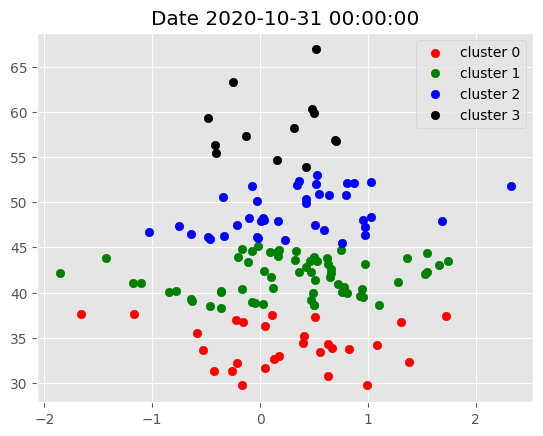

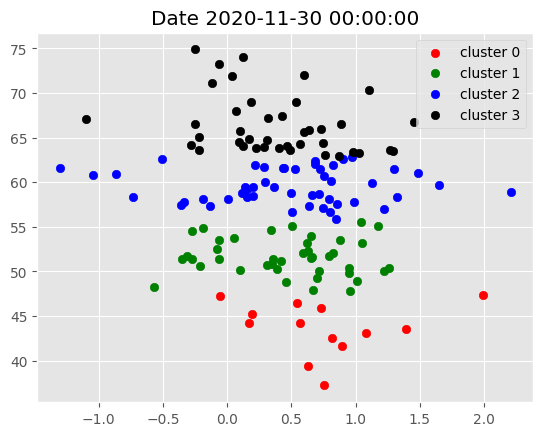

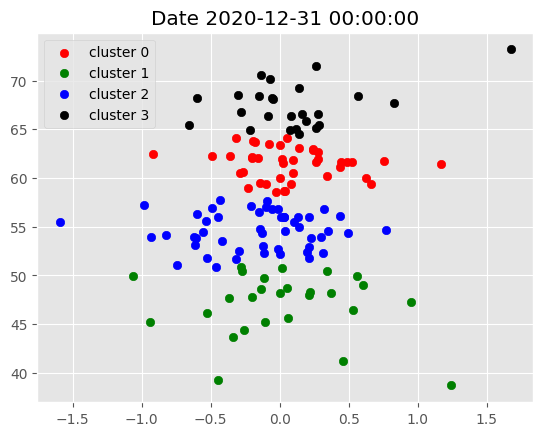

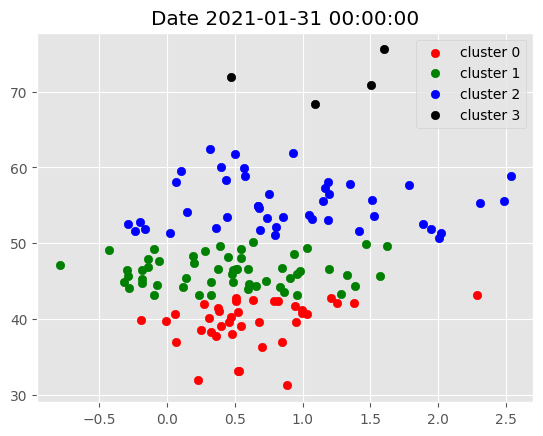

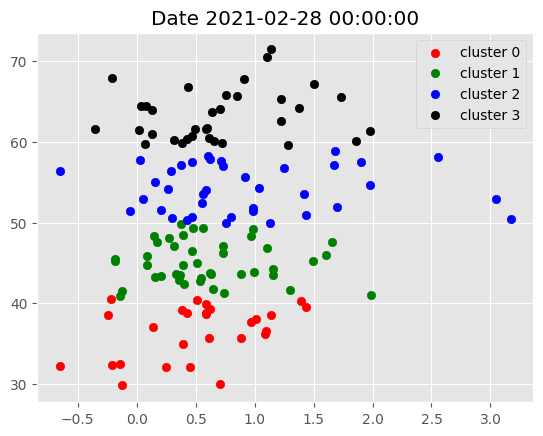

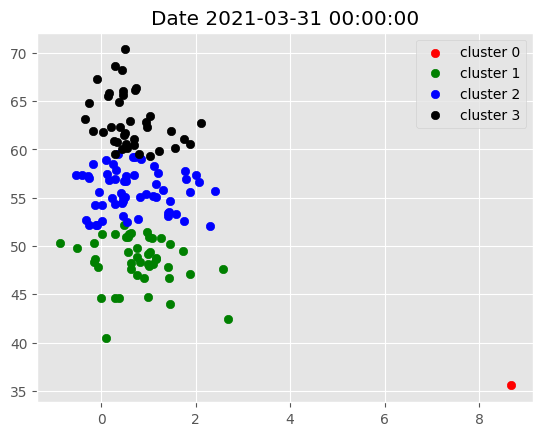

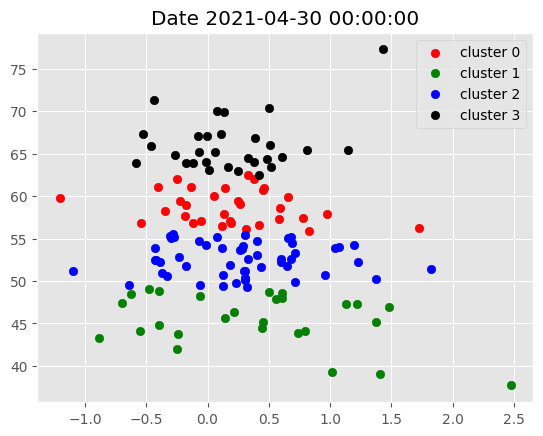

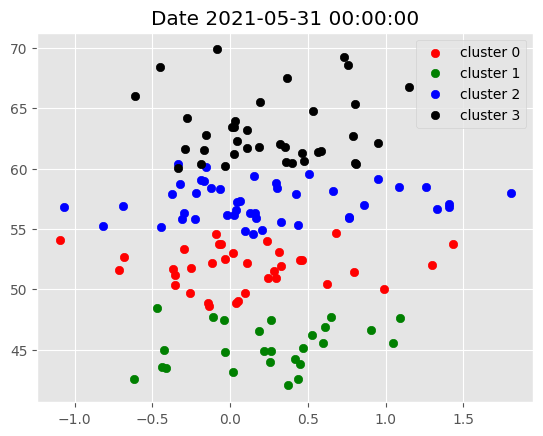

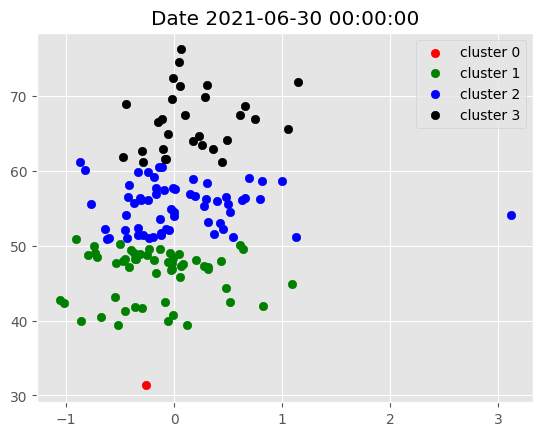

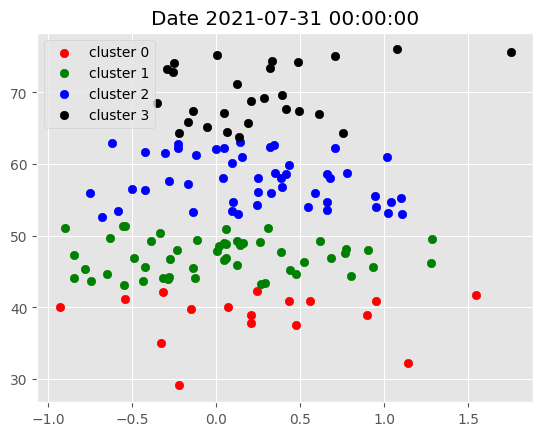

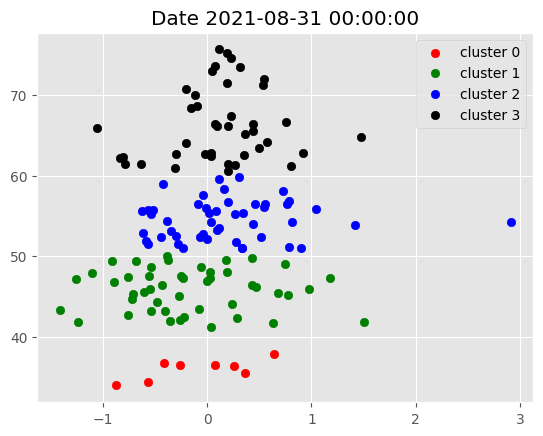

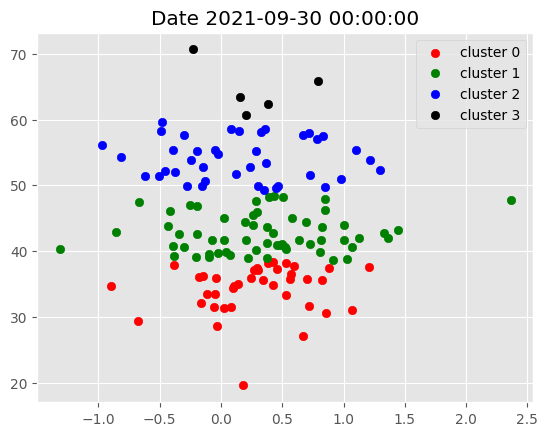

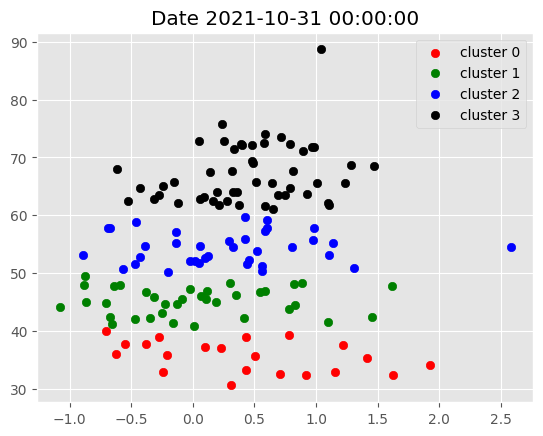

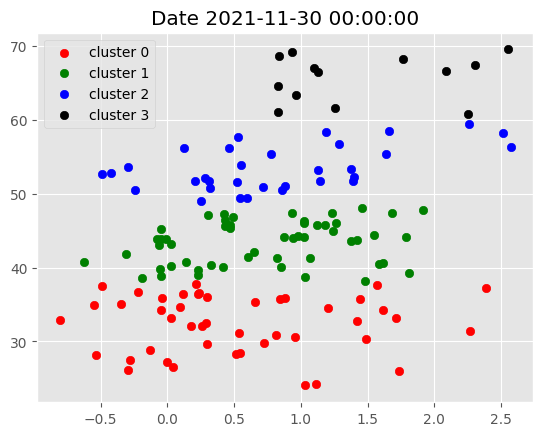

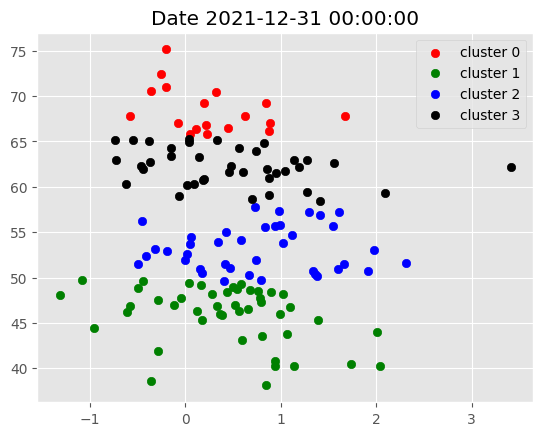

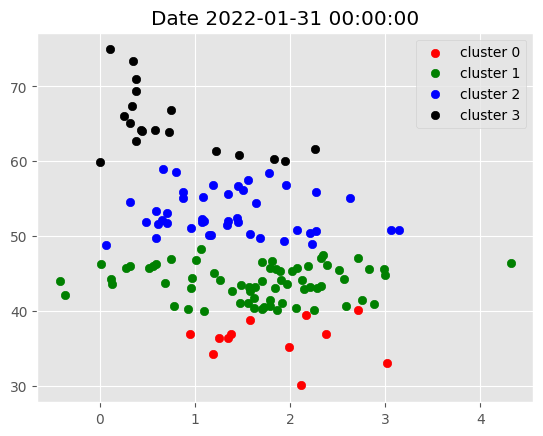

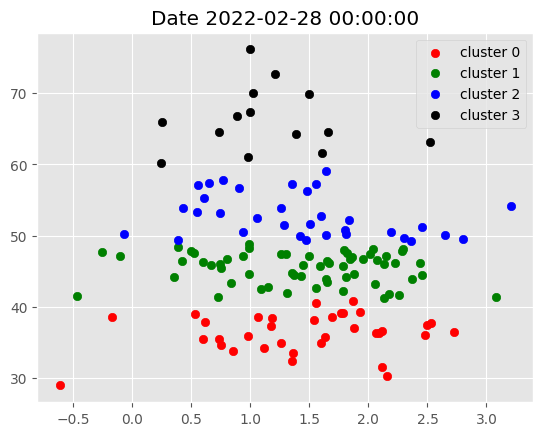

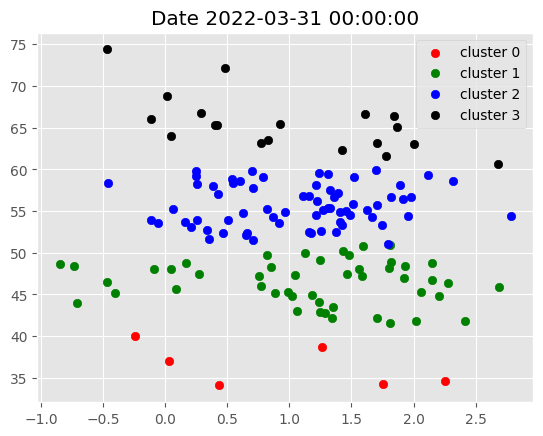

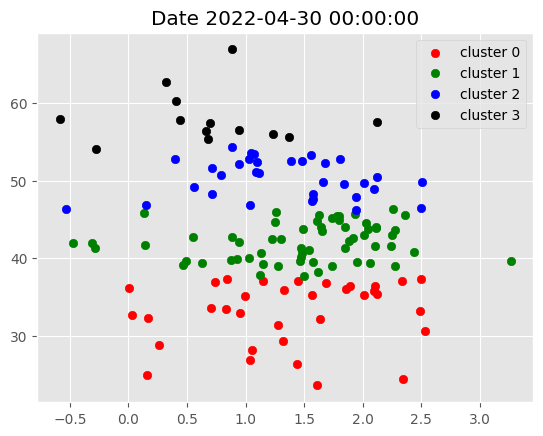

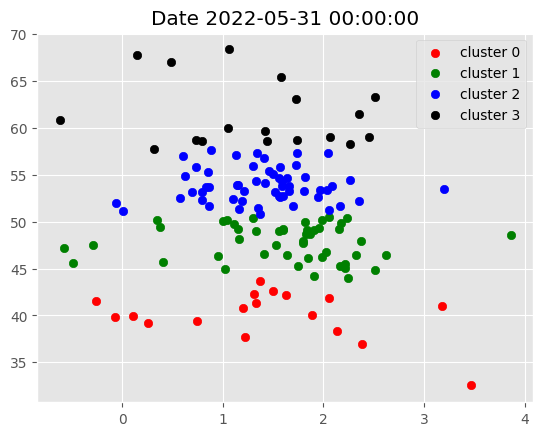

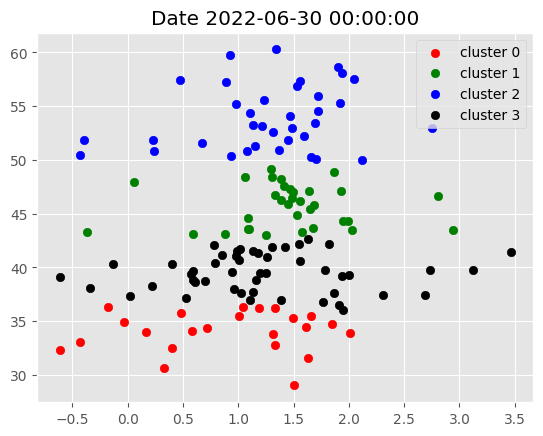

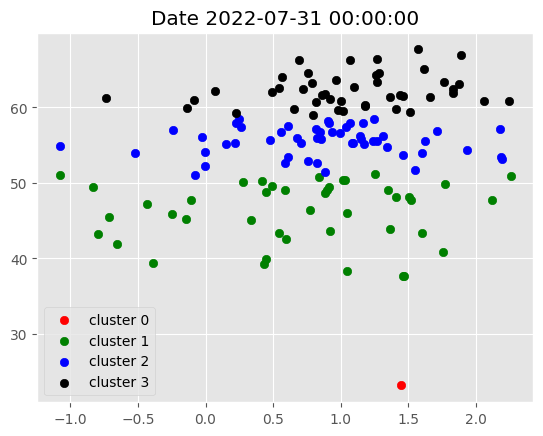

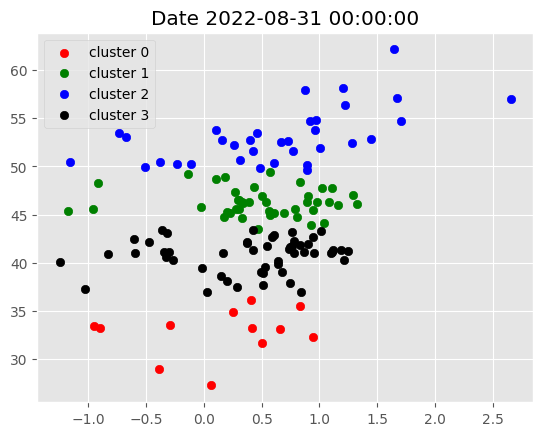

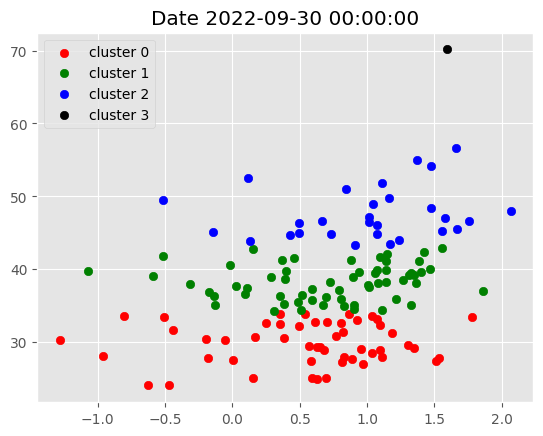

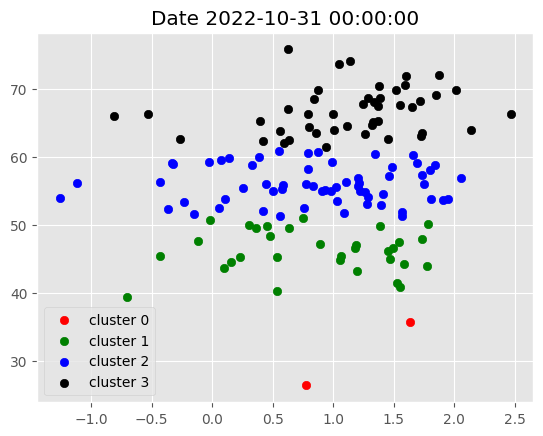

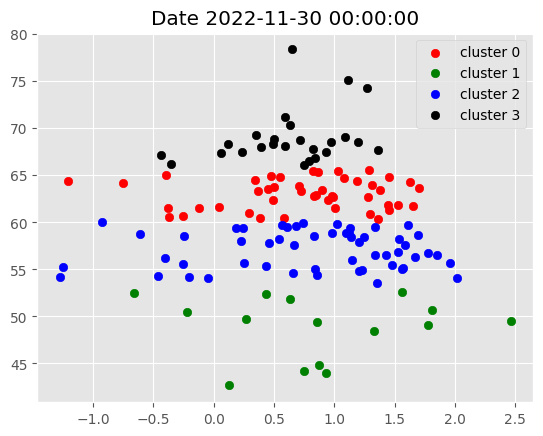

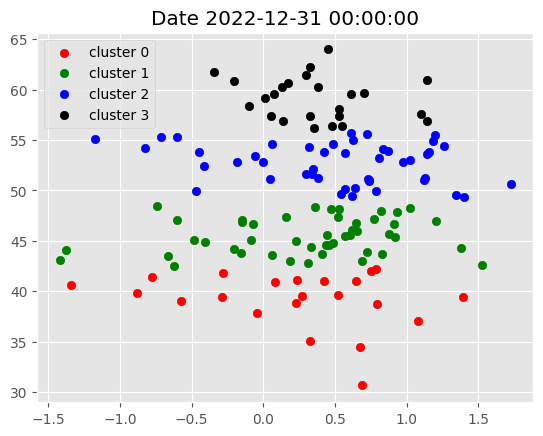

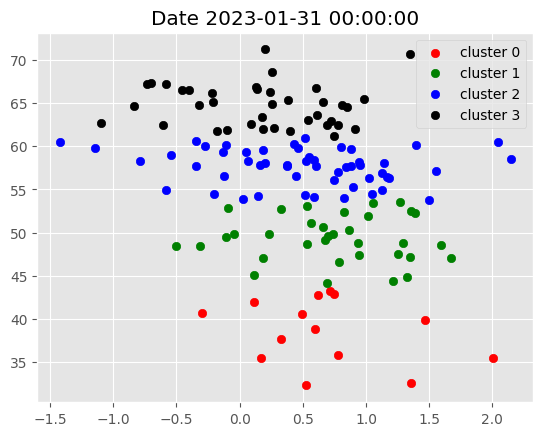

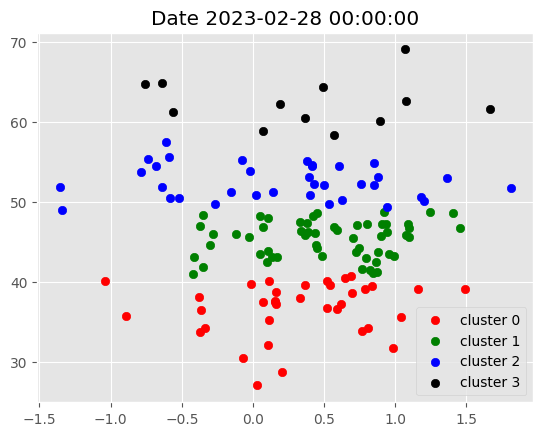

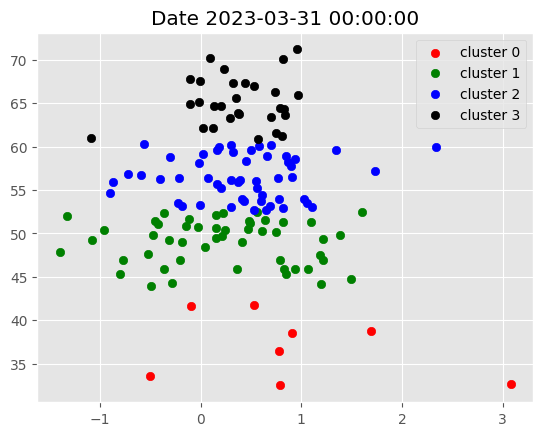

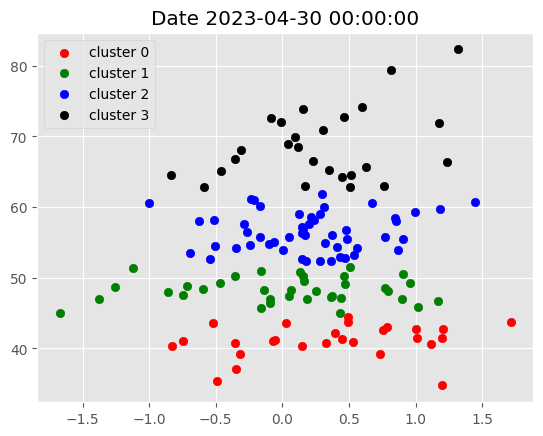

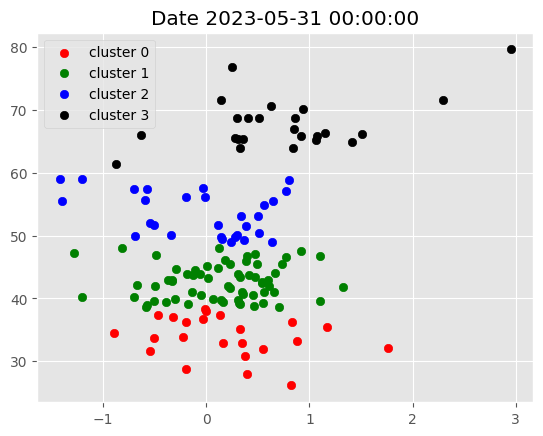

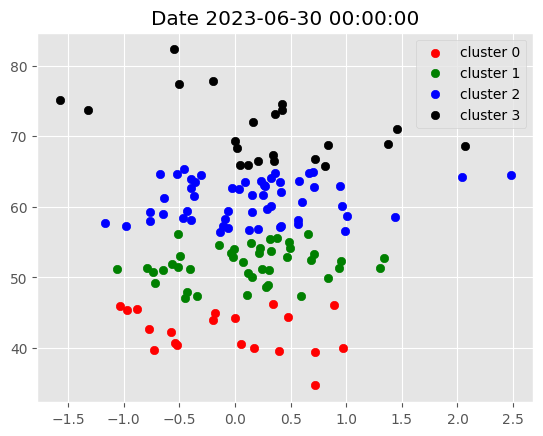

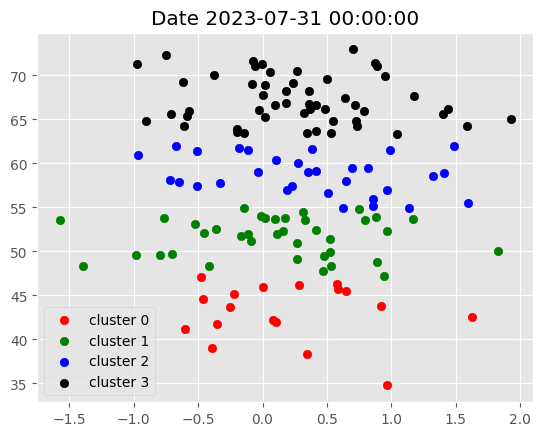

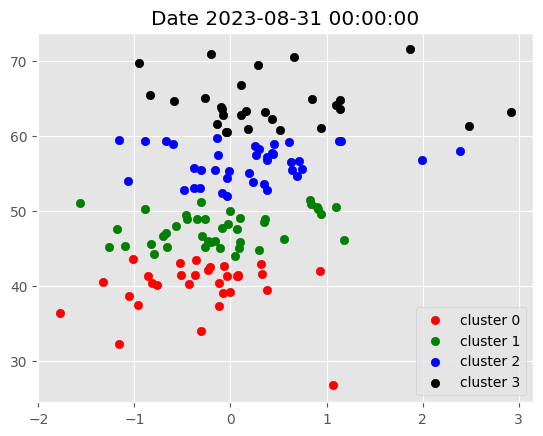

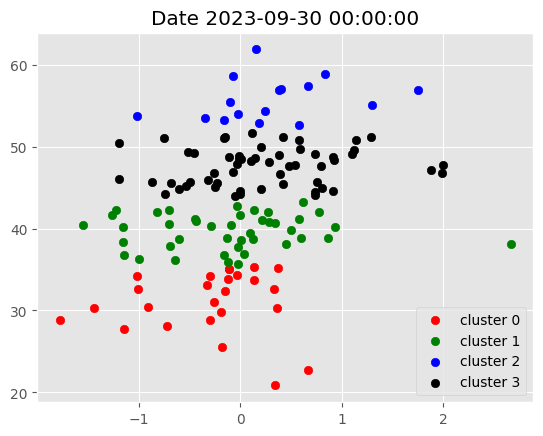

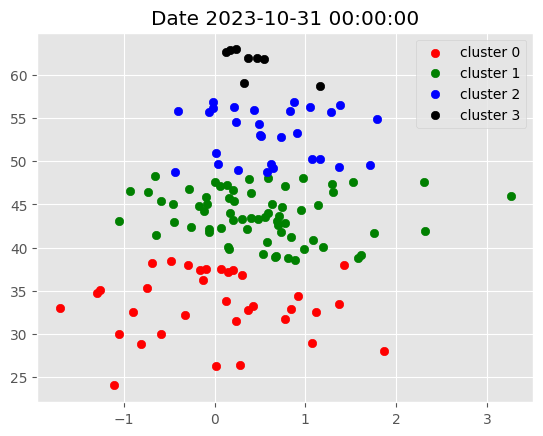

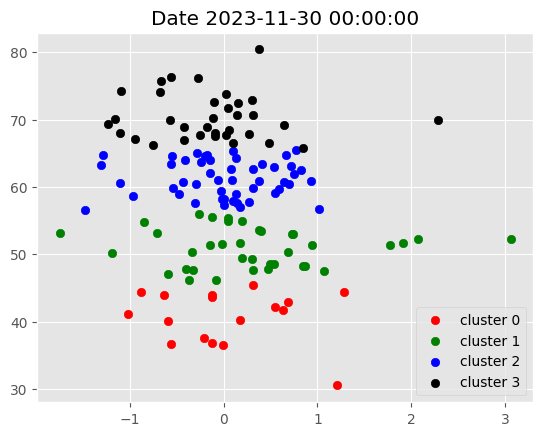

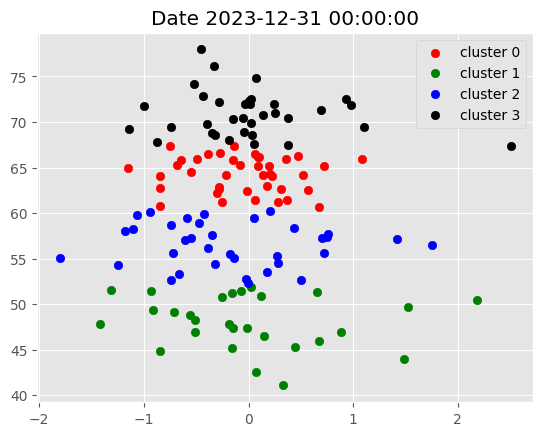

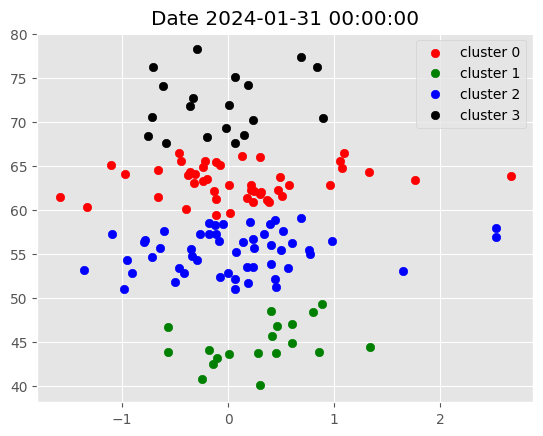

In [ ]:
plt.style.use('ggplot')
#Plotting the cluster with RSI metric
for i in data.index.get_level_values('date').unique().tolist():
  g = data.xs(i,level =0)
  plt.title(f'Date {i}')

  plot_clusters(g)

#For beginning of each new month we are going to select assets based on the cluster and form portfolio based on Efficient Frontier max sharpe ratio optimization

In [ ]:
# Our hypothesis is momentum based


In [ ]:
filtered_df = data[data['cluster']==3].copy()

filtered_df = filtered_df.reset_index(level=1)

filtered_df.index = filtered_df.index+pd.DateOffset(1)

filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])

dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}

for d in dates:

    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()

fixed_dates

{'2018-02-01': ['ABT',
  'ADBE',
  'AMZN',
  'BA',
  'BAC',
  'BRK-B',
  'CHTR',
  'CRM',
  'CTSH',
  'DG',
  'EA',
  'GD',
  'GOOG',
  'GOOGL',
  'JPM',
  'KR',
  'LMT',
  'LOW',
  'MA',
  'MAR',
  'MSFT',
  'NFLX',
  'NKE',
  'NVDA',
  'NXPI',
  'PNC',
  'PYPL',
  'RTX',
  'TMO',
  'V',
  'WFC',
  'WMT'],
 '2018-03-01': ['AAPL',
  'ADBE',
  'AMZN',
  'BA',
  'BKNG',
  'CRM',
  'CSCO',
  'CTSH',
  'INTC',
  'MA',
  'MU',
  'NFLX',
  'NXPI',
  'PANW',
  'TJX'],
 '2018-04-01': ['AMT',
  'BKNG',
  'CL',
  'COP',
  'INTC',
  'NEE',
  'PANW',
  'STZ',
  'TJX',
  'WYNN'],
 '2018-05-01': ['CMG', 'COP', 'EOG', 'HAL', 'OXY', 'PXD', 'ULTA', 'VLO'],
 '2018-06-01': ['ADBE',
  'AMD',
  'AMZN',
  'BIIB',
  'CMG',
  'CSX',
  'EXPE',
  'GM',
  'LLY',
  'LOW',
  'META',
  'NEE',
  'NFLX',
  'OXY',
  'PANW',
  'TJX',
  'TXN',
  'VLO'],
 '2018-07-01': ['ACN',
  'AMT',
  'BSX',
  'COST',
  'CRM',
  'EA',
  'EOG',
  'KR',
  'MDLZ',
  'NEE',
  'NFLX',
  'NKE',
  'PARA',
  'PEP',
  'PG',
  'REGN',
  'SHW',


#Define Portfolio Optimization function

*   Using PyPortfolio function to assign stock weightage to maximize the Sharpe Ratio
*   We need to provide laswt 1 year price to the function
*   Weightage bounds for diversification ( min : half of equal weightage and max: 10% of total portfolio)






In [ ]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

def optimize_weights(prices,lower_bound =0):

  returns = expected_returns.mean_historical_return(prices=prices , frequency =252)

  cov = risk_models.sample_cov(prices = prices , frequency =252)

  ef = EfficientFrontier( returns, cov, weight_bounds = (lower_bound/2,0.1), solver = 'SCS')

  weights = ef.max_sharpe()

  return ef.clean_weights()

In [ ]:
#download fresh daily prices
stocks = data.index.get_level_values('ticker').unique().tolist()

new_df = yf.download(tickers = stocks,
                     start = data.index.get_level_values('date').unique()[0]-pd.DateOffset(months =12 ),
                     end = data.index.get_level_values('date').unique()[-1])



[*********************100%%**********************]  156 of 156 completed


In [ ]:
new_df

Adj Close                                                  \
                  AAL        AAPL        ABBV         ABT         ACN   
Date                                                                    
2017-01-31  42.760242   28.233547   45.380974   37.100910  102.222733   
2017-02-01  42.566975   29.955242   45.217602   37.598309  101.630234   
2017-02-02  42.528328   29.904066   45.217602   37.971367  102.016258   
2017-02-03  42.711937   30.032024   45.054222   37.998020  102.779297   
2017-02-06  43.774906   30.313541   45.039375   37.687126  102.501030   
...               ...         ...         ...         ...         ...   
2024-01-04  13.090000  181.910004  161.460007  110.980003  337.089996   
2024-01-05  13.600000  181.179993  162.139999  110.800003  336.619995   
2024-01-08  14.580000  185.559998  161.429993  112.400002  340.350006   
2024-01-09  14.380000  185.139999  162.309998  112.730003  342.750000   
2024-01-10  14.350000  186.190002  164.889999  114.400002  345.329987   

                                                                       ...  \
                  ADBE         ADP        ADSK        AIG        AMAT  ...   
Date                                                                   ...   
2017-01-31  113.379997   87.153648   81.339996  53.358719   31.547514  ...   
2017-02-01  113.360001   82.200081   81.279999  53.367008   32.265968  ...   
2017-02-02  113.160004   83.123482   82.760002  53.242458   32.183064  ...   
2017-02-03  115.169998   83.598137   84.410004  53.923347   32.523869  ...   
2017-02-06  114.459999   83.252914   82.820000  53.890148   32.404121  ...   
...                ...         ...         ...        ...         ...  ...   
2024-01-04  567.049988  233.660004  228.919998  68.629997  149.309998  ...   
2024-01-05  564.599976  235.210007  229.520004  69.010002  149.000000  ...   
2024-01-08  580.549988  236.759995  235.449997  68.220001  151.559998  ...   
2024-01-09  586.200012  235.220001  235.960007  67.830002  151.029999  ...   
2024-01-10  591.030029  235.289993  238.820007  67.589996  149.809998  ...   

              Volume                                                  \
                   V       VLO     VRTX        VZ       WBA      WDC   
Date                                                                   
2017-01-31   7479400  11657700  2418400  16844200   3424400  3617800   
2017-02-01   7534400   5204500  1754700  26004100   5080000  3897800   
2017-02-02  11142300   6193200  1290800  17787200   3667400  2982700   
2017-02-03  28079600   4416400  1226800  15166400   3167700  2624900   
2017-02-06   9665300   4297800  1423800  16151400   3418400  2307400   
...              ...       ...      ...       ...       ...      ...   
2024-01-04   3843000   2586500  1547200  24214600  60606700  4641000   
2024-01-05   3748400   2958000  1000200  30212900  25898900  4765900   
2024-01-08   4659000   2756500  1142200  28483000  24038200  3390200   
2024-01-09   7055800   2273300  1106100  17880100  17941700  4799000   
2024-01-10   4355300   2713600  1192400  16351800  15359400  4301900   

                                                  
                 WFC      WMT     WYNN       XOM  
Date                                              
2017-01-31  22409100  9320900  1827500  19128100  
2017-02-01  21157700  9050000  3025400  15111800  
2017-02-02  13044400  8998700  1698700  12200100  
2017-02-03  19879800  7625300  1888800  12746300  
2017-02-06  13940200  9097200  2828800   9938200  
...              ...      ...      ...       ...  
2024-01-04  15917500  6427500  1694100  19395200  
2024-01-05  15073600  7235600  2534700  15825000  
2024-01-08  15119700  6893600  1441700  23370100  
2024-01-09  13625200  7774100  1803300  19496600  
2024-01-10  11842200  6703600  1682800  18193700  

[1748 rows x 936 columns]

In [ ]:
returns_dataframe = np.log(new_df['Adj Close']).diff()
portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
  try:
    end_date = (pd.to_datetime(start_date)+ pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')
    cols =fixed_dates[start_date]
    optimization_start_date = (pd.to_datetime(start_date)-pd.DateOffset(months=12 )).strftime('%Y-%m-%d')
    optimization_end_date = (pd.to_datetime(start_date)-pd.DateOffset(days=1 )).strftime('%Y-%m-%d')
    optimization_df = new_df[optimization_start_date:optimization_end_date]['Adj Close'][cols]
    success = False
    try:
      weights =  optimize_weights(prices = optimization_df, lower_bound = round(1/len(optimization_df.columns)/2,3) )
      weights = pd.DataFrame(weights,index = pd.Series(0))
      success = True
    except:
      print(f'Max Sharpe Optimization failed for {start_date}, Continuing with equal weights ')
    if success== False:
      weights = pd.DataFrame([1/len(optimization_df.columns) for i in range(len(optimization_df.columns))],index =optimization_df.columns.tolist(),
                             columns =pd.Series(0)).T

    temp_df = returns_dataframe[start_date:end_date]
    temp_df = temp_df.stack().to_frame('return').reset_index(level =0)\
        .merge(weights.stack().to_frame('weight').reset_index(level =0, drop = True),
                left_index =True,
                right_index = True)\
        .reset_index().set_index(['Date','index']).unstack().stack()

    temp_df.index.names = ['date', 'ticker']

    temp_df['weighted_return'] = temp_df['return']*temp_df['weight']

    temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('Strategy Return')

    portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)

  except Exception as e:
    print(e)

portfolio_df = portfolio_df.drop_duplicates()
portfolio_df

Max Sharpe Optimization failed for 2018-05-01, Continuing with equal weights 
Max Sharpe Optimization failed for 2020-03-01, Continuing with equal weights 
Max Sharpe Optimization failed for 2020-04-01, Continuing with equal weights 
Max Sharpe Optimization failed for 2021-02-01, Continuing with equal weights 
Max Sharpe Optimization failed for 2021-10-01, Continuing with equal weights 
Max Sharpe Optimization failed for 2022-10-01, Continuing with equal weights 
Max Sharpe Optimization failed for 2023-11-01, Continuing with equal weights 
'return'


,Strategy Return
date,
2018-02-01,-0.009300
2018-02-02,-0.015667
2018-02-05,-0.040584
2018-02-06,0.016496
2018-02-07,0.003086
...,...
2024-01-04,0.001815
2024-01-05,0.006210
2024-01-08,0.017691


#Compare our results with Sp 500 and Visulaize returns

In [ ]:
spy = yf.download(tickers= 'SPY',
                  start = '2015-01-01',
                  end= dt.date.today())

spy_ret = np.log(spy[['Adj Close']]).diff().dropna().rename({'Adj Close':'SPY Buy and Hold'},axis =1)
spy_ret

[*********************100%%**********************]  1 of 1 completed


,SPY Buy and Hold
Date,
2015-01-05,-0.018225
2015-01-06,-0.009463
2015-01-07,0.012384
2015-01-08,0.017589
2015-01-09,-0.008046
...,...
2024-01-04,-0.003226
2024-01-05,0.001369
2024-01-08,0.014175


In [ ]:
spy = yf.download(tickers='SPY',
                  start='2015-01-01',
                  end=dt.date.today())

spy_ret = np.log(spy[['Adj Close']]).diff().dropna().rename({'Adj Close':'SPY Buy&Hold'}, axis=1)

portfolio_df = portfolio_df.merge(spy_ret,
                                  left_index=True,
                                  right_index=True)

portfolio_df

[*********************100%%**********************]  1 of 1 completed


,Strategy Return,SPY Buy&Hold
2018-02-01,-0.009300,-0.001136
2018-02-02,-0.015667,-0.022010
2018-02-05,-0.040584,-0.042722
2018-02-06,0.016496,0.019511
2018-02-07,0.003086,-0.005439
...,...,...
2024-01-04,0.001815,-0.003226
2024-01-05,0.006210,0.001369
2024-01-08,0.017691,0.014175
2024-01-09,0.001485,-0.001518


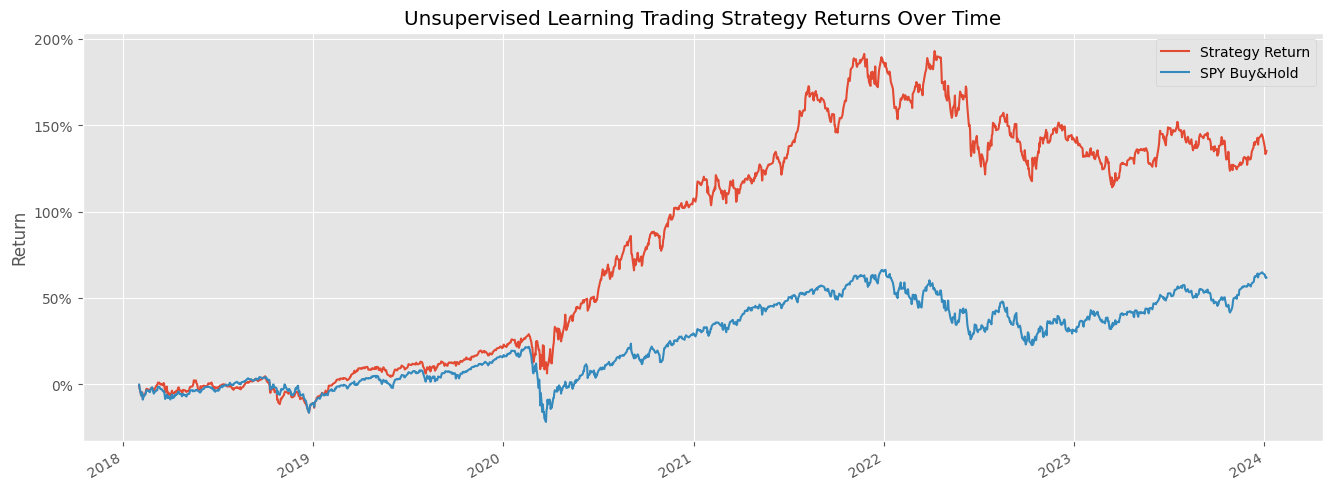

In [ ]:
import matplotlib.ticker as mtick
plt.style.use('ggplot')
portfolio_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum())-1
portfolio_cumulative_return[:'2024-01-05'].plot(figsize= (16,6))


plt.title('Unsupervised Learning Trading Strategy Returns Over Time')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()